# Using CellTypist for cell type classification
This notebook showcases the cell type classification for scRNA-seq query data by retrieving the most likely cell type labels from the built-in CellTypist models.

In [1]:
import celltypist
from celltypist import models
import pandas as pd

In [2]:
DATASET_ROOT = "./dataset"
DATASET_NAMES = ["PBMC1", "PBMC2", "PBMC3", "PBMC4"]
CELLTYPIST_MODEL = ['Immune_All_Low.pkl', 'Immune_All_Low.pkl', 'Immune_All_Low.pkl', 'Immune_All_Low.pkl']
DATASET_DIR = [f"{DATASET_ROOT}/{name}" for name in DATASET_NAMES]
FILTERED_DATASET_DIR = [f"{DATASET_ROOT}/{name}-filtered" for name in DATASET_NAMES]
FILTERED_DATASET_DIR_10X = [x + "/10x" for x in FILTERED_DATASET_DIR]

In [3]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = False)

📂 Storing models in /Users/irenetesta/.celltypist/data/models
⏩ Skipping [1/44]: Immune_All_Low.pkl (file exists)
⏩ Skipping [2/44]: Immune_All_High.pkl (file exists)
⏩ Skipping [3/44]: Adult_CynomolgusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [4/44]: Adult_Human_PancreaticIslet.pkl (file exists)
⏩ Skipping [5/44]: Adult_Human_Skin.pkl (file exists)
⏩ Skipping [6/44]: Adult_Mouse_Gut.pkl (file exists)
⏩ Skipping [7/44]: Adult_Mouse_OlfactoryBulb.pkl (file exists)
⏩ Skipping [8/44]: Adult_Pig_Hippocampus.pkl (file exists)
⏩ Skipping [9/44]: Adult_RhesusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [10/44]: Autopsy_COVID19_Lung.pkl (file exists)
⏩ Skipping [11/44]: COVID19_HumanChallenge_Blood.pkl (file exists)
⏩ Skipping [12/44]: COVID19_Immune_Landscape.pkl (file exists)
⏩ Skipping [13/44]: Cells_Fetal_Lung.pkl (file exists)
⏩ Skipping [14/44]: Cells_Intestinal_Tract.pkl (file exists)
⏩ Skipping [15/44]: Cells_Lung_Airway.pkl (file exists)
⏩ Skipping [16/44]: Developing_Human

In [4]:
def annotate_10x_dataset(datadir, model_name, out_dir):
    input_matrix = datadir + "/matrix.mtx"
    gene_file = datadir + '/genes.tsv'
    gene_id_file = datadir + "/gene_ids.csv"
    cell_id_file = datadir + "/barcodes.tsv"

    genes = pd.read_csv(gene_file, sep='\t', header=None)
    gene_ids = genes[0]
    gene_ids.to_csv(gene_id_file, index=False, header=False)

    predictions = celltypist.annotate(
        input_matrix,
        model = model_name,
        transpose_input = True,
        majority_voting = True,
        mode = 'best match',
        gene_file=gene_id_file,
        cell_file=cell_id_file
    )
    labels = predictions.predicted_labels
    labels = labels.rename(columns={"majority_voting": "Cluster"})
    labels.reset_index(inplace=True, names='Barcode')
    labels = labels[["Barcode", "Cluster"]]

    annotation_df = labels.copy()

    mapping = {label: i for i, label in enumerate(labels['Cluster'].unique())}

    mapping_df = pd.DataFrame({'go': labels['Cluster'].unique()})
    mapping_df.reset_index(inplace=True, names='id')
    mapping_df['id'] = mapping_df['id'] + 1
    mapping_df.to_csv(out_dir + "/celltypist_mapping.csv", index=False)
    
    labels['Cluster'] = labels['Cluster'].map(mapping)
    labels['Cluster'] = labels['Cluster'].astype(int)
    labels['Cluster'] = labels['Cluster'] + 1
    labels.to_csv(out_dir + "/celltypist_labels.csv", index=False)

    return annotation_df

In [6]:
annotations = {}
for i in range(len(DATASET_NAMES)):
    print(f"Annotating {DATASET_NAMES[i]}...")
    annotations[DATASET_NAMES[i]] = annotate_10x_dataset(FILTERED_DATASET_DIR_10X[i], CELLTYPIST_MODEL[i], FILTERED_DATASET_DIR[i])

📁 Input file is './dataset/PBMC1-filtered/10x/matrix.mtx'
⏳ Loading data


Annotating PBMC1...


🔬 Input data has 5469 cells and 14088 genes
🔗 Matching reference genes in the model
🧬 4605 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!
📁 Input file is './dataset/PBMC2-filtered/10x/matrix.mtx'
⏳ Loading data


Annotating PBMC2...


🔬 Input data has 7901 cells and 954 genes
🔗 Matching reference genes in the model
🧬 728 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!
📁 Input file is './dataset/PBMC3-filtered/10x/matrix.mtx'
⏳ Loading data


Annotating PBMC3...


🔬 Input data has 364775 cells and 174 genes
🔗 Matching reference genes in the model
🧬 171 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 30
🗳️ Majority voting the predictions
✅ Majority voting done!
📁 Input file is './dataset/PBMC4-filtered/10x/matrix.mtx'
⏳ Loading data


Annotating PBMC4...


🔬 Input data has 148524 cells and 184 genes
🔗 Matching reference genes in the model
🧬 182 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


In [37]:
#save annotation counts as csv
annotation_counts = {}
for i in range(len(DATASET_NAMES)):
    annotation_counts[DATASET_NAMES[i]] = annotations[DATASET_NAMES[i]]['Cluster'].value_counts()
    annotation_counts[DATASET_NAMES[i]].to_csv(f"{FILTERED_DATASET_DIR[i]}/celltypist_annotation_counts.csv")

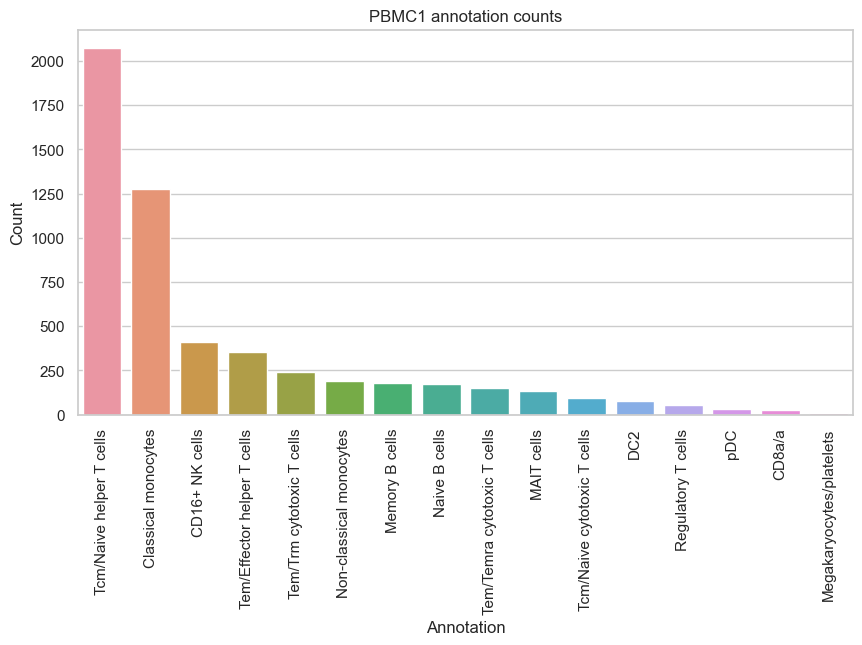

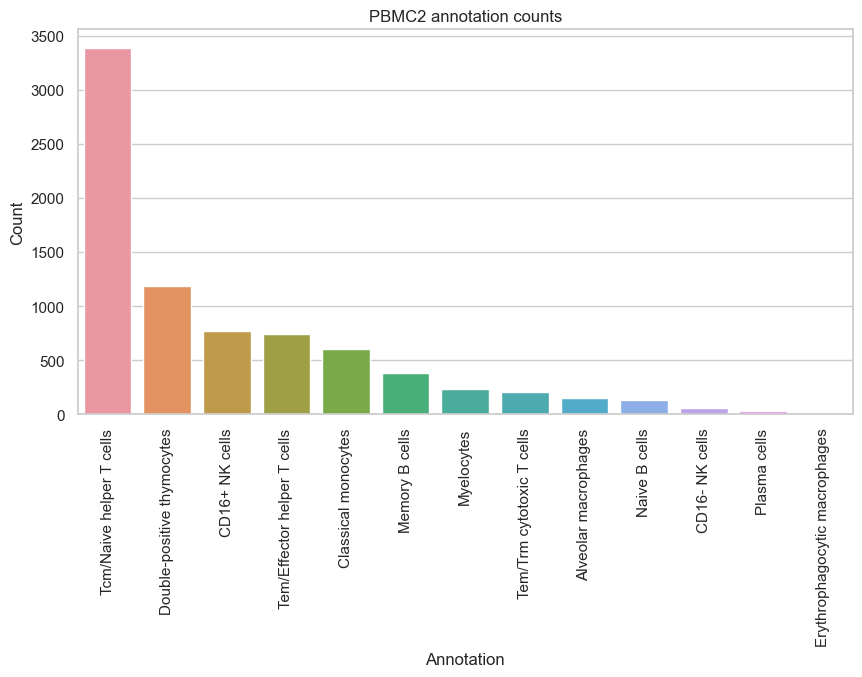

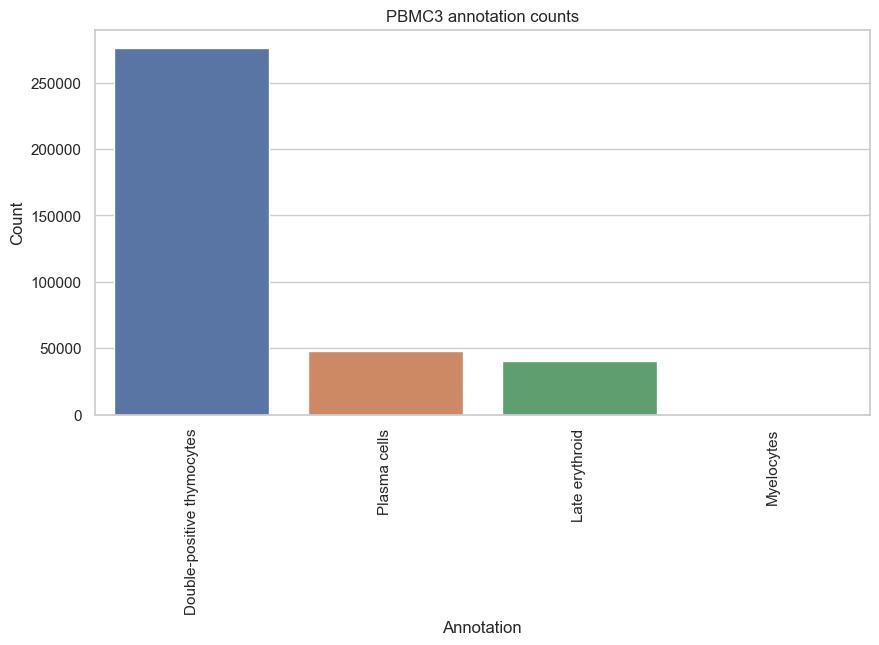

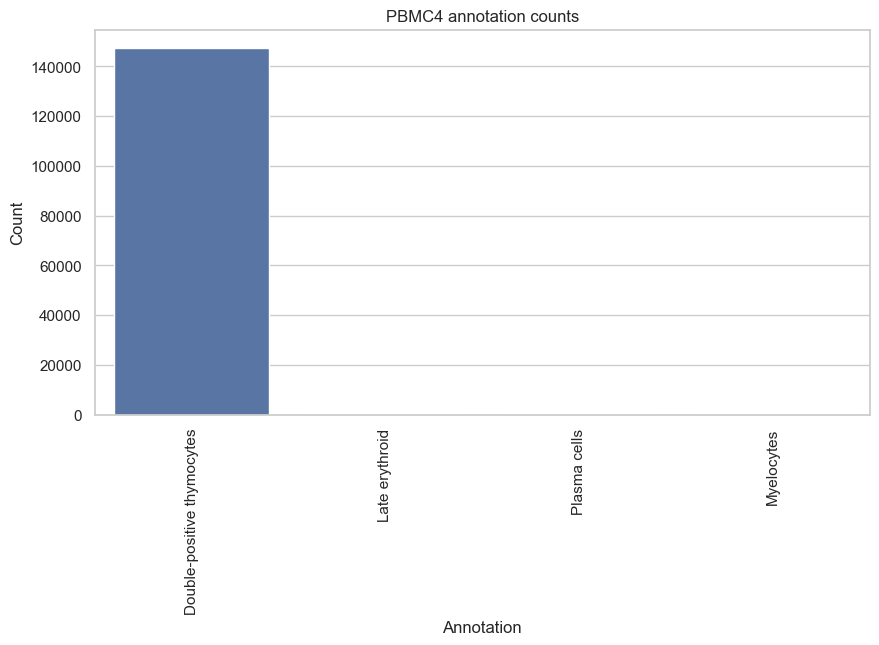

In [38]:
#visualize annotation counts
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

for i in range(len(DATASET_NAMES)):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x=annotation_counts[DATASET_NAMES[i]].index, y=annotation_counts[DATASET_NAMES[i]].values)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(f"{DATASET_NAMES[i]} annotation counts")
    ax.set_xlabel("Annotation")
    ax.set_ylabel("Count")
    plt.savefig(f"{FILTERED_DATASET_DIR[i]}/celltypist_annotation_counts.png", bbox_inches='tight')
    plt.show()